In [0]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split 
from keras.initializers import RandomNormal
from keras.layers import Dense, Input, Reshape, Dropout, ZeroPadding2D
from sklearn.preprocessing import MultiLabelBinarizer , LabelEncoder
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df2 = pd.read_csv('/content/drive/My Drive/FinalProject822/peptide_data/HLA_peptide_allele_tissue.tsv',delimiter='\t')
# np.random.seed(1337)
noise_dim = 50
batch_size = 256
output_dim= 36
epochs = 500
optimizer = Adam(0.0002, 0.5)


Real


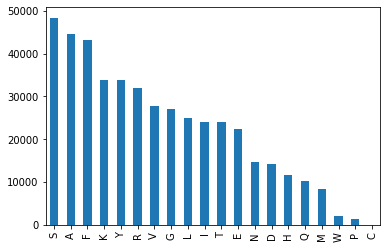

In [0]:

amino = df2['peptide_sequence'].astype(str).str[0]
print('Real')
amino.value_counts().plot(kind='bar')

In [0]:
df2

,peptide_sequence_id,peptide_sequence,tissue_name,hla_type_class,hla_type_name,predicted_affinity
0,7079,FSRFLNKQPY,Kidney,class1,B*35:01,weak
1,10038,ALFDGDPHL,Adrenal Gland,class1,C*03:04,weak
2,3248,KQYERSIVDY,Lung,class1,B*15:01,strong
3,1888,YQTAISENY,Uterus,class1,B*35:01,weak
4,12356,YYIRETENF,Heart,class1,C*06:02,weak
...,...,...,...,...,...,...
449400,30904,GEWDKALSI,Spleen,class1,B*49:01,strong
449401,7850,YFRDQEGQDV,Bone Marrow,class1,C*04:01,strong
449402,50046,KPPKPVSKMRMATPLLMQALP,Tongue,class2,DQA1*01:02-DQB1*03:03,weak
449403,50046,KPPKPVSKMRMATPLLMQALP,Esophagus,class2,DRB4*01:01,strong


real


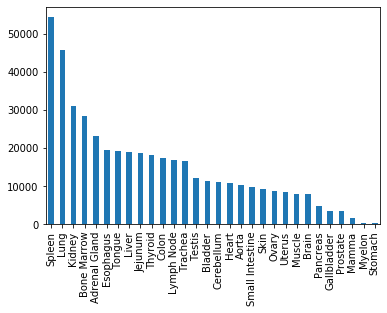

In [0]:
print('real')
df2['tissue_name'].value_counts().plot(kind='bar')



real


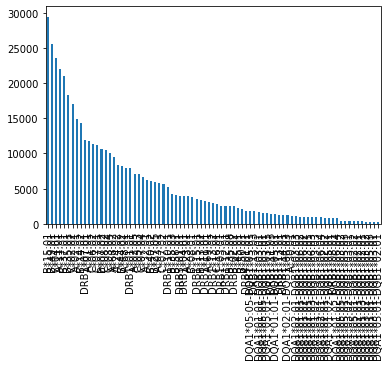

In [0]:
print('real')
df2['hla_type_name'].value_counts().plot(kind='bar')


real


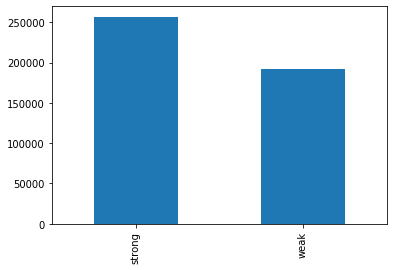

In [0]:
print('real')
df2['predicted_affinity'].value_counts().plot(kind='bar')


In [0]:
encoder_tissue = LabelEncoder()
train_tissue = df2['tissue_name']
#print(train_tissue)
train_tissue = encoder_tissue.fit_transform(train_tissue)
train_tissue = train_tissue.reshape((train_tissue.shape[0], 1))
#print(train_tissue.shape)
#print(encoder_tissue.inverse_transform(train_tissue))

# train_x_2.describe()
# encoder.inverse_transform(train_x_2[:100])
# train_x_2

In [0]:
encoder_class = LabelBinarizer()
#encoder_class = MultiLabelBinarizer()
train_class = df2['hla_type_class']
train_class = encoder_class.fit_transform(train_class)
train_class.shape

(449405, 1)

In [0]:
encoder_name = LabelEncoder()
train_name = df2['hla_type_name']
train_name = encoder_name.fit_transform(train_name)
print(train_name.shape)
train_name = train_name.reshape((train_name.shape[0], 1))
train_name.shape


(449405,)


(449405, 1)

In [0]:
encoder_affinity = LabelBinarizer()
train_affinity = df2['predicted_affinity']
train_affinity = encoder_affinity.fit_transform(train_affinity)


In [0]:
train_sequence = df2['peptide_sequence']

tokenizer = Tokenizer(lower=False, char_level=True)
tokenizer.fit_on_texts(train_sequence)

train_sequence = tokenizer.texts_to_sequences(train_sequence)
train_sequence = pad_sequences(train_sequence, maxlen=32)
# max(list(map(len, train_sequence)))

# np.amax(train_sequence)


In [0]:

print(train_sequence.shape)
print(train_tissue.shape)
print(train_class.shape)
print(train_name.shape)
print(train_affinity.shape)


(449405, 32)
(449405, 1)
(449405, 1)
(449405, 1)
(449405, 1)


In [0]:
train_x = np.concatenate((train_sequence, 
                          train_tissue, 
                          train_class, 
                          train_name, 
                          train_affinity), 
                         axis=1)

In [0]:
train_x[0:5]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  6,  4, 13,  6,  1, 16, 10, 12, 11,  9,
        11,  0, 18,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  3,  1,  6, 15, 14, 15, 11, 17,  1,
         0,  0, 30,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, 10, 12,  9,  7, 13,  4,  5,  2, 15,  9,
        13,  0, 16,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  9, 12,  8,  3,  5,  4,  7, 16,  9,
        29,  0, 18,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  9,  9,  5, 13,  7,  8,  7, 16,  6,
         9,  0, 32,  1]])

In [0]:
def create_generator(noise_dim, out_dim):
    generator = Sequential()
##
    generator.add(Dense(256,input_dim = noise_dim))
    generator.add(LeakyReLU(0.2));

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2));

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(out_dim))
    generator.add(LeakyReLU(0.2))

    generator.compile(loss='binary_crossentropy',
                      optimizer = optimizer)

    return generator

In [0]:
# model1 = create_generator(50, 36)
# summarize the model
# model1.summary()
# plot the model
# plot_model(model1, to_file='/content/drive/My Drive/generator_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
def create_descriminator(input_dimension):
    discriminator = Sequential()
     
    discriminator.add(Dense(1024, input_dim=input_dimension))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', 
                          optimizer=optimizer, 
                          metrics=['accuracy'])
    return discriminator

In [0]:
# modeld = create_descriminator(36)
# summarize the model
# modeld.summary()
# plot the model
# plot_model(modeld, to_file='/content/drive/My Drive/discriminator_plot.png', show_shapes=True, show_layer_names=True)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 36)                706852    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 694273    
Total params: 1,401,125
Trainable params: 706,852
Non-trainable params: 694,273
_________________________________________________________________


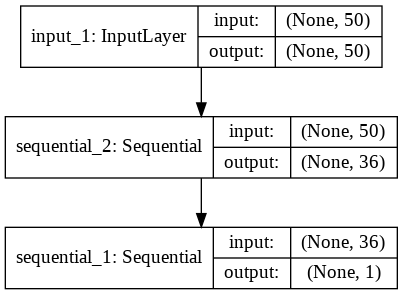

In [0]:

discriminator = create_descriminator(output_dim)

generator = create_generator(noise_dim, output_dim)

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_sequence = generator(gan_input)

gan_output = discriminator(fake_sequence)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
gan.summary()
plot_model(gan,show_shapes=True,show_layer_names=True)

In [0]:
# Display images, and save them if the epoch number is specified
def show_images():
    noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
    generated_images = generator.predict(noise)
    
    
    for i, image in enumerate(generated_images):
        image = tokenizer.sequences_to_texts(train_x)
        print(image)


In [0]:

# batches = train_x.shape[0] / batch_size
temp1 = []
temp2 = []
for epoch in range(epochs):

    d_loss = 10.0
    count = 0
    while d_loss > 0.001:
        if count > 100:
            break 

        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))

        real_x = train_x[np.random.randint(0, train_x.shape[0], size=batch_size)]
        fake_x = generator.predict(noise)

        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 1.0

        d_loss, d_acc =  discriminator.train_on_batch(x, disc_y)
        temp1.append([d_loss, d_acc])

        count += 1
    g_loss = 10.0
    count = 0
    while g_loss > 0.001:
        if count > 100:
            break 
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))

        y_gen = np.ones(batch_size)
        g_loss, g_acc = gan.train_on_batch(noise, y_gen)

        temp2.append([g_loss, g_acc])
        count += 1

    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss}, acc: {d_acc} \t\t Generator Loss: {g_loss}, acc: {g_acc}')

generator.save('/content/drive/My Drive/generator.h5')
gan.save('/content/drive/My Drive/gan.h5')
discriminator.save('/content/drive/My Drive/discriminator.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 	 Discriminator Loss: 0.0188650730997324, acc: 0.99609375 		 Generator Loss: 0.010422027669847012, acc: 1.0
Epoch: 1 	 Discriminator Loss: 0.008551564998924732, acc: 1.0 		 Generator Loss: 0.025017956271767616, acc: 1.0
Epoch: 2 	 Discriminator Loss: 0.005817382130771875, acc: 1.0 		 Generator Loss: 0.030851632356643677, acc: 1.0
Epoch: 3 	 Discriminator Loss: 0.03495900705456734, acc: 0.994140625 		 Generator Loss: 0.04747627675533295, acc: 1.0
Epoch: 4 	 Discriminator Loss: 0.02037433534860611, acc: 0.990234375 		 Generator Loss: 0.025138195604085922, acc: 1.0
Epoch: 5 	 Discriminator Loss: 0.013645587489008904, acc: 1.0 		 Generator Loss: 0.03724519535899162, acc: 1.0
Epoch: 6 	 Discriminator Loss: 0.011399446986615658, acc: 0.998046875 		 Generator Loss: 0.02466295100748539, acc: 1.0
Epoch: 7 	 Discriminator Loss: 0.017001496627926826, acc: 0.998046875 		 Generator Loss: 0.03274252265691757, acc: 1.0
Epoch: 8 	 Discriminator Loss: 0.022946499288082123, acc: 0.9921875 		 Ge

In [0]:
loaded_model = load_model('/content/drive/My Drive/generator.h5')

In [0]:
peptide_num = 10000
noise = np.random.normal(0, 1, size=(peptide_num, noise_dim))
#generated_sequence = generator.predict(noise)
generated_sequence = loaded_model.predict(noise)
print(generated_sequence)
generated_sequence = generated_sequence.astype(int)
"""
inverse_transform(train_x_2[:100])
train_x = np.concatenate((train_sequence, 
                          train_tissue, 
                          train_class, 
                          train_name, 
                          train_affinity), 
                         axis=1)
encoder_class, encoder_name, encoder_affinity, encoder_tissue
peptide_sequence	tissue_name	hla_type_class	hla_type_name	predicted_affinity
(449405, 32)
(449405, 30)
(449405, 1)
(449405, 81)
(449405, 1)
"""
generated_sequence

[[-3.4701472e-04 -1.7090550e-03 -8.5344408e-03 ... -6.9411495e-03
   2.9306318e+01 -2.8589970e-02]
 [-4.2824540e-04 -6.3568228e-03 -1.5091333e-02 ... -1.2963409e-02
   3.3963882e+01  9.7720003e-01]
 [ 9.1734761e-03 -7.4944088e-05 -5.7643526e-03 ... -6.4560734e-03
   6.0537510e+00 -3.2713861e-04]
 ...
 [-1.9608163e-03 -9.5060561e-04 -5.8823237e-03 ... -2.9309641e-03
   1.4665411e+01  1.9427642e-02]
 [-1.3495203e-03 -1.9223702e-03 -5.2529890e-03 ... -8.4266122e-03
   7.4439669e+00  1.0449185e+00]
 [ 6.9187237e-03 -2.5244532e-03 -5.8123223e-03 ... -1.4154755e-03
   1.6834656e+01  9.5392770e-01]]


array([[ 0,  0,  0, ...,  0, 29,  0],
       [ 0,  0,  0, ...,  0, 33,  0],
       [ 0,  0,  0, ...,  0,  6,  0],
       ...,
       [ 0,  0,  0, ...,  0, 14,  0],
       [ 0,  0,  0, ...,  0,  7,  1],
       [ 0,  0,  0, ...,  0, 16,  0]])

In [0]:
a = train_sequence.shape[1]
b = a + train_tissue.shape[1]
c = b + train_class.shape[1]
d = c + train_name.shape[1]
e = d + train_affinity.shape[1]

#print(generated_sequence[0][a:b])
result = []
for i in range(peptide_num):

  try:
    generated_text = tokenizer.sequences_to_texts([generated_sequence[i][:a]])[0]
    tissue = encoder_tissue.inverse_transform(generated_sequence[i][a:b].reshape(b-a, 1))[0]
    type_class = encoder_class.inverse_transform(generated_sequence[i][b:c].reshape(c-b, 1))[0]
    type_name = encoder_name.inverse_transform(generated_sequence[i][c:d].reshape(d-c,1))[0]
    affinity = encoder_affinity.inverse_transform(generated_sequence[i][d:].reshape(e-d,1))[0]
  
    print({
        'peptide_sequence':generated_text,
        'tissue_name':tissue,
        'hla_type_class':type_class,
        'hla_type_name':type_name,
        'predicted_affinity':affinity
    })
    my_details = {
        'peptide_sequence':generated_text,
        'tissue_name':tissue,
        'hla_type_class':type_class,
        'hla_type_name':type_name,
        'predicted_affinity':affinity
    }
    result.append(my_details)
  except:
    continue

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'peptide_sequence': 'N N S G F S V Y I', 'tissue_name': 'Uterus', 'hla_type_class': 'class1', 'hla_type_name': 'C*03:03', 'predicted_affinity': 'strong'}
{'peptide_sequence': 'D L Y C T I T L', 'tissue_name': 'Muscle', 'hla_type_class': 'class1', 'hla_type_name': 'C*07:01', 'predicted_affinity': 'strong'}
{'peptide_sequence': 'T T Q V T Y V', 'tissue_name': 'Ovary', 'hla_type_class': 'class1', 'hla_type_name': 'A*24:02', 'predicted_affinity': 'strong'}
{'peptide_sequence': 'I G V I M H Y', 'tissue_name': 'Mamma', 'hla_type_class': 'class1', 'hla_type_name': 'A*01:01', 'predicted_affinity': 'strong'}
{'peptide_sequence': 'T P L F P Y Q F', 'tissue_name': 'Esophagus', 'hla_type_class': 'class1', 'hla_type_name': 'B*35:08', 'predicted_affinity': 'strong'}
{'peptide_sequence': 'S P R I K T L V', 'tissue_name': 'Stomach', 'hla_type_class': 'class1', 'hla_type_name': 'A*30:01', 'predicted_affinity': 'strong'}
{'peptide_sequence': 'Y A L E Q D P', 'tissue_name': 'Adrenal Gland', 'hla_type_cl

(9110, 5)
fake


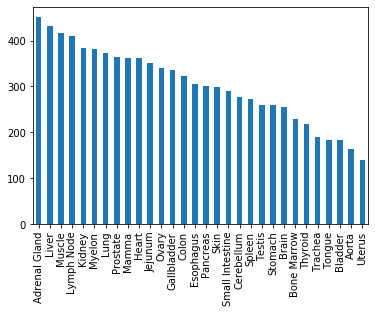

In [0]:
#Observation2:Plot of number of tissues count for the generated tissue count
result_data =  pd.DataFrame(result)
print(result_data.shape)
print('fake')
result_data['tissue_name'].value_counts().plot(kind='bar')

#visual
#visual.hist()
#plt.ylabel('Frequency')
#plt.xlabel('Tissue')
#plt.title('Histogram')
#result_data

fake


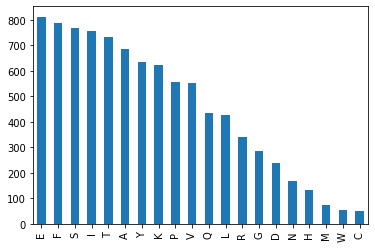

In [0]:
#Observation2:Highest starting character for the peptide generated sequence 
print('fake')
result_data['extra'] = result_data['peptide_sequence'].astype(str).str[0]
visual2 = result_data['extra'].value_counts().plot(kind='bar')

fake


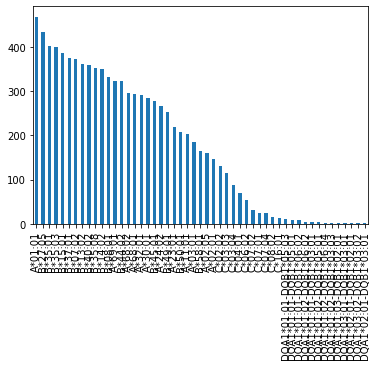

In [0]:
#Observation3:Most repeating hla type classes produced for generated peptides
print('fake')
result_data['hla_type_name'].value_counts().plot(kind='bar')


fake


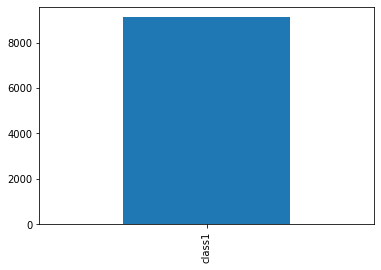

In [0]:
print('fake')
result_data['hla_type_class'].value_counts().plot(kind='bar')

fake


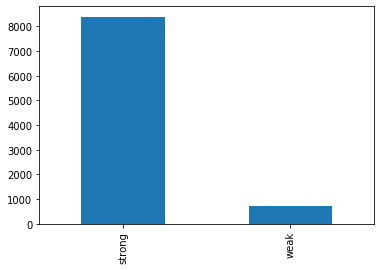

In [0]:
print('fake')
result_data['predicted_affinity'].value_counts().plot(kind='bar')